In [216]:
import soundfile # to read audio file
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, to_categorical

In [245]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if (len(X.shape) != 1):
            if (X.shape[1] == 2):
                X = X[:,0]
            else:
                return [None]
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [246]:
## codes in data
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# only files with these emotion labels are used
emotions_dict ={
    "angry": 0,
    "sad": 1,
    "neutral": 2,
    "happy": 3
}

category_to_emotion = {}

for key in emotions_dict.keys():
    value = emotions_dict[key]
    category_to_emotion[value] = key

In [247]:
def load_data(test_size=0.2, max_amount=10000):
    i = 0
    X, y = [], []
    amount = 0
    for file in glob.glob("ravdess/Audio*/Actor_*/*.wav"):
        if (amount >= max_amount):
            break
        
        basename = os.path.basename(file)
        
        emotion = int2emotion[basename.split("-")[2]]
        allowed_emotions = emotions_dict.keys()
        
        if emotion not in allowed_emotions:
            continue
        emotion_category = emotions_dict[emotion]
        
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        
        ## there seems to be some unusable data so lets get rid of those
        if (features[0] == None):
            continue
        
        
            
        X.append(features)
        y.append(emotion_category)
        amount = amount + 1
        
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [248]:
max_amount_of_data = 10000
X_train, X_test, y_train, y_test = load_data(test_size=0.25, max_amount=max_amount_of_data)

In [249]:

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


y_train = np.asarray(y_train)
y_train = y_train.astype(np.float32)
y_test = np.asarray(y_test)
y_test = y_test.astype(np.float32)

nb_classes = len(emotions_dict.keys())

y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

In [250]:
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])


[+] Number of training samples: 987
[+] Number of testing samples: 329
[+] Number of features: 180


In [251]:
print("[+] X_train first value's first 5 values", X_train[0][0:5])
print("[+] y_train first value", y_train[0])

[+] X_train first value's first 5 values [-665.39246     97.90721     -4.6756134   13.205296     4.945498 ]
[+] y_train first value [0. 1. 0. 0.]


In [252]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_traincnn.shape

(987, 180, 1)

In [253]:
inputs = keras.Input(shape=(x_traincnn.shape[1], x_traincnn.shape[2]))
x = layers.Conv1D(128, 5, activation="relu", padding="same")(inputs)

x = layers.Dropout(rate=0.1)(x)

x = layers.MaxPooling1D(pool_size=(8))(x)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(units=output_units, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="mlp_model")
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
print(model.summary())

Model: "mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 180, 1)]          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 180, 128)          768       
_________________________________________________________________
dropout_22 (Dropout)         (None, 180, 128)          0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 22, 128)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 22, 128)           82048     
_________________________________________________________________
dropout_23 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 2816)              0 

In [254]:
epochs = 200

history = model.fit(x_traincnn, y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    verbose=2)

Epoch 1/200
31/31 - 3s - loss: 2.9407 - accuracy: 0.2898
Epoch 2/200
31/31 - 1s - loss: 2.9299 - accuracy: 0.3019
Epoch 3/200
31/31 - 1s - loss: 2.6101 - accuracy: 0.3100
Epoch 4/200
31/31 - 1s - loss: 2.3739 - accuracy: 0.3100
Epoch 5/200
31/31 - 1s - loss: 2.2690 - accuracy: 0.3354
Epoch 6/200
31/31 - 1s - loss: 2.1956 - accuracy: 0.3465
Epoch 7/200
31/31 - 1s - loss: 2.1804 - accuracy: 0.3536
Epoch 8/200
31/31 - 1s - loss: 1.9922 - accuracy: 0.3556
Epoch 9/200
31/31 - 1s - loss: 1.9398 - accuracy: 0.3627
Epoch 10/200
31/31 - 1s - loss: 1.8249 - accuracy: 0.3830
Epoch 11/200
31/31 - 1s - loss: 1.8162 - accuracy: 0.3820
Epoch 12/200
31/31 - 1s - loss: 1.7878 - accuracy: 0.3982
Epoch 13/200
31/31 - 1s - loss: 1.6851 - accuracy: 0.4103
Epoch 14/200
31/31 - 1s - loss: 1.6482 - accuracy: 0.4195
Epoch 15/200
31/31 - 1s - loss: 1.5648 - accuracy: 0.4063
Epoch 16/200
31/31 - 1s - loss: 1.5274 - accuracy: 0.4245
Epoch 17/200
31/31 - 1s - loss: 1.5269 - accuracy: 0.4174
Epoch 18/200
31/31 - 1s

Epoch 142/200
31/31 - 1s - loss: 0.6438 - accuracy: 0.7508
Epoch 143/200
31/31 - 1s - loss: 0.6489 - accuracy: 0.7325
Epoch 144/200
31/31 - 1s - loss: 0.6629 - accuracy: 0.7224
Epoch 145/200
31/31 - 1s - loss: 0.6489 - accuracy: 0.7376
Epoch 146/200
31/31 - 1s - loss: 0.6425 - accuracy: 0.7285
Epoch 147/200
31/31 - 1s - loss: 0.6361 - accuracy: 0.7508
Epoch 148/200
31/31 - 1s - loss: 0.6385 - accuracy: 0.7619
Epoch 149/200
31/31 - 1s - loss: 0.6391 - accuracy: 0.7528
Epoch 150/200
31/31 - 1s - loss: 0.6383 - accuracy: 0.7548
Epoch 151/200
31/31 - 1s - loss: 0.6391 - accuracy: 0.7477
Epoch 152/200
31/31 - 1s - loss: 0.6326 - accuracy: 0.7528
Epoch 153/200
31/31 - 1s - loss: 0.6268 - accuracy: 0.7528
Epoch 154/200
31/31 - 1s - loss: 0.6282 - accuracy: 0.7487
Epoch 155/200
31/31 - 1s - loss: 0.6310 - accuracy: 0.7437
Epoch 156/200
31/31 - 1s - loss: 0.6346 - accuracy: 0.7528
Epoch 157/200
31/31 - 1s - loss: 0.6332 - accuracy: 0.7416
Epoch 158/200
31/31 - 1s - loss: 0.6090 - accuracy: 0.75

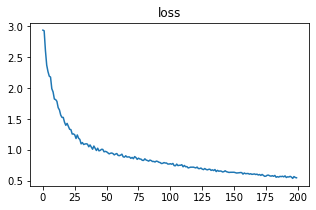

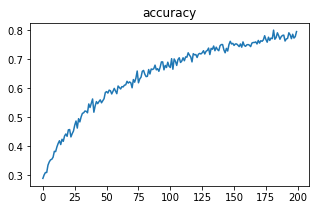

In [255]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [258]:
scores = model.evaluate(x_testcnn, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

11/11 - 0s - loss: 0.6020 - accuracy: 0.7508
accuracy: 75.08%


In [260]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(x_testcnn)
print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), labels=list(range(4)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print(f"{i} ({category_to_emotion[i]}): {j}")

Confusion matrix (rows: true classes; columns: predicted classes):

[[83  2  1 14]
 [ 2 63 15 19]
 [ 0  7 31  7]
 [ 5  9  1 70]]

Classification accuracy for each class:

0 (angry): 0.83
1 (sad): 0.6363636363636364
2 (neutral): 0.6888888888888889
3 (happy): 0.8235294117647058


# Testing on youtube videos

In [261]:
from pydub import AudioSegment
import math
import shutil


In [262]:
parent_dir = os.getcwd() + "\\test_yt_data"
temp_path = os.path.join(parent_dir, "tmp")
try:
    shutil.rmtree(temp_path)
except:
    None

In [ ]:
#

X = []
X_names = []
video_names = []
split_video_names = []
## split each video to 3 second videos and make predictions to those
for file in glob.glob("test_yt_data/*.wav"):
        file_splits = []
        basename = os.path.basename(file)
        sound = AudioSegment.from_file(file)
        three_seconds = 3 * 1000
        length = len(sound)
        splits_amount = math.ceil(length/three_seconds)
        i = 0
        parent_dir = os.getcwd() + "\\test_yt_data"
        temp_path = os.path.join(parent_dir, "tmp")
        os.mkdir(temp_path, 0o666)
        
        while (i < splits_amount):
            start_index = i * three_seconds
            end_index = start_index + three_seconds
            split = sound[start_index:end_index]
            basename_without_ext = basename.split(".")[0]
            split_video_name = f"{basename_without_ext}_split_{i}.wav"
            path = f"test_yt_data/tmp/{split_video_name}"
            split.export(path, format="wav")
            split_video_names.append(split_video_name)
            X_names.append(split_video_name)
            i = i + 1
        
        for file in glob.glob("test_yt_data/tmp/*.wav"):
            features = extract_feature(file, mfcc=True, chroma=True, mel=True)
            file_splits.append(features)
        shutil.rmtree(temp_path)
        video_names.append(basename)
        X.append(file_splits)

X = np.array(X)
X = X.astype(np.float32)

C:\Users\ossij\anaconda3\envs\ids-proj\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [237]:
print(X.shape)

(1, 19, 180)


In [238]:
split_video_index = 0
for ids, values in enumerate(X):
    print("Predicting values for video '" + f"{X_names[ids]}")
    for index, val in enumerate(values):
        y_hat = model.predict( np.array( [val,] )  )[0]
        predicted = y_hat.argmax()

        emotion = category_to_emotion[predicted]
        print("Predicted emotion for split '" + f"{split_video_names[split_video_index]}" +  "' is:")
        print(emotion)
        print()
        split_video_index = split_video_index + 1

Predicting values for video 'tie_a_tie_1_minute_split_0.wav
Predicted emotion for split 'tie_a_tie_1_minute_split_0.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_1.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_2.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_3.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_4.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_5.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_6.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_7.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_8.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_9.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_10.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_11.wav' is:
angry

Predicted emotion for split 'tie_a_tie_1_minute_split_12.wav' is:
angry

P